<a href="https://colab.research.google.com/github/pengyk/COMP551/blob/main/Copy_of_Copy_of_mini_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import math



In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
cases_df = pd.read_csv("drive/My Drive/COMP551/assignment1/aggregated_cc_by.csv")
trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_weekly_symptoms_dataset.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
trends_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [44]:
# Getting all us states
us_states = trends_df.open_covid_region_code.unique()
print(us_states)

['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


In [45]:
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
pd.set_option('display.max_rows', us_cases.shape[0]+1)
print(us_cases)

     open_covid_region_code           region_name        date  hospitalized_new
0                     US-WY               Wyoming  2020-03-07               0.0
1                     US-WY               Wyoming  2020-03-08               0.0
2                     US-WY               Wyoming  2020-03-09               0.0
3                     US-WY               Wyoming  2020-03-10               0.0
4                     US-WY               Wyoming  2020-03-11               0.0
5                     US-WY               Wyoming  2020-03-12               0.0
6                     US-WY               Wyoming  2020-03-13               0.0
7                     US-WY               Wyoming  2020-03-14               0.0
8                     US-WY               Wyoming  2020-03-15               0.0
9                     US-WY               Wyoming  2020-03-16               0.0
10                    US-WY               Wyoming  2020-03-17               0.0
11                    US-WY             

In [46]:
def clean_data(df):
  (rows, cols) = df.shape
  print(rows, cols)
  row_threshold = int(rows * 0.05)
  col_threshold = int(cols * 0.05)

  df = df.dropna(axis = 0, thresh = row_threshold)
  df = df.dropna(axis = 1, thresh = col_threshold)
  df = df.reset_index(drop = True)
  (rows, cols) = df.shape
  print(rows, cols)
  return df

In [47]:
us_cases.columns

Index(['open_covid_region_code', 'region_name', 'date', 'hospitalized_new'], dtype='object')

In [48]:
def group_data_by_weeks(df):
  df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
  df = df.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code','date'])
  return df

us_cases = group_data_by_weeks(us_cases)

In [49]:
print("Before cleaning:")
print(trends_df.shape)

# trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)

Before cleaning:
(608, 430)
After cleaning:
(608, 430)


In [50]:
trends_df['date'] = pd.to_datetime(trends_df['date'])
complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
# print(us_cases['open_covid_region_code'].unique())
# print(trends_df['open_covid_region_code'].unique())
complete_df.head()
# print(complete_df['open_covid_region_code'].unique())

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-02,NaN,NaN,NaN,NaN,NaN,14.62,NaN,NaN,NaN,NaN,NaN,9.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.46,NaN,NaN,NaN,...,NaN,19.43,NaN,NaN,NaN,NaN,NaN,12.96,NaN,NaN,NaN,NaN,21.76,11.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.29,10.46,NaN,NaN,14.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-09,NaN,NaN,NaN,NaN,NaN,10.60,NaN,NaN,11.61,NaN,NaN,12.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.07,NaN,NaN,7.91,NaN,NaN,NaN,NaN,NaN,13.80,NaN,NaN,NaN,...,NaN,11.11,NaN,NaN,NaN,NaN,NaN,13.97,NaN,NaN,NaN,NaN,46.95,10.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.26,NaN,NaN,NaN,18.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.77,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-16,NaN,NaN,NaN,NaN,NaN,11.69,NaN,NaN,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.59,NaN,NaN,7.95,NaN,NaN,NaN,NaN,NaN,11.07,NaN,NaN,NaN,...,NaN,14.49,NaN,NaN,NaN,NaN,NaN,9.04,NaN,NaN,NaN,NaN,78.71,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.53,NaN,NaN,NaN,24.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.34,NaN,NaN,0.0
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-23,NaN,NaN,NaN,NaN,NaN,11.15,16.57,NaN,NaN,NaN,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.39,NaN,NaN,NaN,...,NaN,7.63,NaN,NaN,NaN,NaN,NaN,8.36,NaN,NaN,NaN,NaN,37.54,8.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.75,7.04,NaN,NaN,13.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.69,NaN,NaN,7.0
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-30,NaN,NaN,NaN,NaN,NaN,8.96,8.96,NaN,7.11,NaN,NaN,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.94,NaN,NaN,NaN,...,NaN,9.38,NaN,NaN,NaN,NaN,NaN,14.79,NaN,NaN,NaN,NaN,24.46,9.81,NaN,NaN,7.96,NaN,NaN,NaN,NaN,NaN,7.54,7.11,NaN,NaN,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.63,NaN,NaN,16.0


# Function to pick top 4

In [51]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
tdf = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

print(tdf)
print(tdf['open_covid_region_code'].unique())
complete_df.head()

   open_covid_region_code  ...                            4th Max
0                   US-AK  ...                   symptom:Asphyxia
1                   US-DC  ...                     symptom:Ptosis
2                   US-DE  ...                  symptom:Hypomania
3                   US-HI  ...                 symptom:Laryngitis
4                   US-ID  ...               symptom:Osteoporosis
5                   US-ME  ...                  symptom:Hemolysis
6                   US-MT  ...                     symptom:Chorea
7                   US-ND  ...                   symptom:Asphyxia
8                   US-NE  ...               symptom:Osteoporosis
9                   US-NH  ...          symptom:Shallow breathing
10                  US-NM  ...               symptom:Osteoporosis
11                  US-RI  ...  symptom:Clouding of consciousness
12                  US-SD  ...                    symptom:Anosmia
13                  US-VT  ...                   symptom:Dystonia
14        

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-02,NaN,NaN,NaN,NaN,NaN,14.62,NaN,NaN,NaN,NaN,NaN,9.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.46,NaN,NaN,NaN,...,NaN,19.43,NaN,NaN,NaN,NaN,NaN,12.96,NaN,NaN,NaN,NaN,21.76,11.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.29,10.46,NaN,NaN,14.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,NaN,NaN,0.0
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-09,NaN,NaN,NaN,NaN,NaN,10.60,NaN,NaN,11.61,NaN,NaN,12.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.07,NaN,NaN,7.91,NaN,NaN,NaN,NaN,NaN,13.80,NaN,NaN,NaN,...,NaN,11.11,NaN,NaN,NaN,NaN,NaN,13.97,NaN,NaN,NaN,NaN,46.95,10.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.26,NaN,NaN,NaN,18.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.77,NaN,NaN,0.0
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-16,NaN,NaN,NaN,NaN,NaN,11.69,NaN,NaN,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.59,NaN,NaN,7.95,NaN,NaN,NaN,NaN,NaN,11.07,NaN,NaN,NaN,...,NaN,14.49,NaN,NaN,NaN,NaN,NaN,9.04,NaN,NaN,NaN,NaN,78.71,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.53,NaN,NaN,NaN,24.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.34,NaN,NaN,0.0
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-23,NaN,NaN,NaN,NaN,NaN,11.15,16.57,NaN,NaN,NaN,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.39,NaN,NaN,NaN,...,NaN,7.63,NaN,NaN,NaN,NaN,NaN,8.36,NaN,NaN,NaN,NaN,37.54,8.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.75,7.04,NaN,NaN,13.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.69,NaN,NaN,7.0
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-30,NaN,NaN,NaN,NaN,NaN,8.96,8.96,NaN,7.11,NaN,NaN,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.94,NaN,NaN,NaN,...,NaN,9.38,NaN,NaN,NaN,NaN,NaN,14.79,NaN,NaN,NaN,NaN,24.46,9.81,NaN,NaN,7.96,NaN,NaN,NaN,NaN,NaN,7.54,7.11,NaN,NaN,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.63,NaN,NaN,16.0


# Function to run K-Means

In [61]:
def classify_KMeans(complete_df):
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  X = complete_df.drop(complete_df.iloc[:, :9], axis = 1)
  X = X.drop(['hospitalized_new'], axis = 1)

  range_n_clusters = list(range(5, 40))

  best_average = 0
  best_K = 0

  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_average:
      best_average = silhouette_avg
      best_k = n_clusters
  
  print("best number of clusters is: ", best_k)
  X = TSNE(n_components=2).fit_transform(X)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

For n_clusters = 5 The average silhouette_score is : 0.3357808473391936
For n_clusters = 6 The average silhouette_score is : 0.33106529276167485
For n_clusters = 7 The average silhouette_score is : 0.3284680655076633
For n_clusters = 8 The average silhouette_score is : 0.33732819578441314
For n_clusters = 9 The average silhouette_score is : 0.3348841785974677
For n_clusters = 10 The average silhouette_score is : 0.34942072625144477
For n_clusters = 11 The average silhouette_score is : 0.36976900489588865
For n_clusters = 12 The average silhouette_score is : 0.37156795175015733
For n_clusters = 13 The average silhouette_score is : 0.3857350554499824
For n_clusters = 14 The average silhouette_score is : 0.3872739459477003
For n_clusters = 15 The average silhouette_score is : 0.40791751184352903
For n_clusters = 16 The average silhouette_score is : 0.41977698689218385
For n_clusters = 17 The average silhouette_score is : 0.42959835677619157
For n_clusters = 18 The average silhouette_score

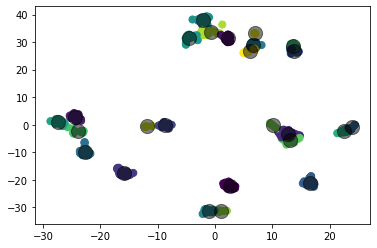

In [62]:
classify_KMeans(complete_df)

# function to plot

In [ ]:
def plot_data(symptoms_df, complete_df):
  symptoms_df = tdf

  # def plot_data(symptoms_df, complete_df):
  # for loop to 
  for index, row in symptoms_df.iterrows():
    # print(row)
    # get region
    region = symptoms_df.open_covid_region_code[index]
    # get the dataframe with this region
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    # print(region_df)
    # get the number of date / number of bins in the histogram
    n_bins = len(region_df)
    # the 4 colours for our 4 most searched symptoms
    # colors = ['red', 'green', 'blue', 'tan']
    # our data in (number of dates, number of symptoms)
    X = np.zeros([4, n_bins])
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      symptom = row.iloc[i + 1]
      # break
      j = 0
      for j, region_row in region_df.iterrows():
        # print(region_row[symptom])
        # print(i)
        # print(j)
        X[i, j] = region_row[symptom]
      plt.plot(X[i])
    print(X)    
    plt.show()
    # break

# Plot the data

In [ ]:
plot_data(only_symptoms_df,complete_df)

In [ ]:
def knn_classifier(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  # splitted = None
  # if going by region
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,41):
      if i % 2 == 0:
        continue
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title('By Region')
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))


In [ ]:
knn_classifier(complete_df, 'region')

In [ ]:
knn_classifier(complete_df, 'time')

In [ ]:
def decisionTree_regressor(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  # splitted = None
  # if going by region
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,40):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title(','.join(test_list))
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate)))

In [ ]:
decisionTree_regressor(complete_df, 'region')